In [55]:
import torch
import math
from collections import deque
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import kornia 
import cv2
import kornia.filters as filters
plt.rcParams['figure.figsize'] = [13, 9]

# 1 - Canny Edge Detection

In [80]:
def MyCanny(img, sigma, tau):
    
    # step 1: smooth out the image using a 2d gaussian
    smoothed = kornia.filters.gaussian_blur2d(tensor_img_gray, (3, 3), (sigma,sigma))

    # step 2: compute the gradient and squared gradient magnitude
    dx_kernel = torch.tensor([[-1, 0, 1],
                          [-2, 0, 2],
                          [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    dy_kernel = torch.tensor([[-1, -2, -1],
                          [ 0,  0,  0],
                          [ 1,  2,  1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    dx = F.conv2d(smoothed, dx_kernel)
    dy = F.conv2d(smoothed, dy_kernel)

    mag = torch.sqrt(dx ** 2 + dy ** 2)
    theta = torch.atan2(dy, dx)
    
    # step 3: perform non maximum suppression
    rows, cols = mag.shape[2:]
    suppressed = torch.zeros_like(mag)
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            # convert radians to degrees
            angle = theta[0, 0, i, j].item() * 180.0 / math.pi
            if angle < 0:
                angle += 180.0
            # round the angle to the nearest 45 degrees
            if (angle >= 0 and angle < 22.5) or (angle >= 157.5 and angle < 180):
                q = mag[0, 0, i, j+1]
                r = mag[0, 0, i, j-1]
            elif (angle >= 22.5 and angle < 67.5):
                q = mag[0, 0, i+1, j+1]
                r = mag[0, 0, i-1, j-1]
            elif (angle >= 67.5 and angle < 112.5):
                q = mag[0, 0, i+1, j]
                r = mag[0, 0, i-1, j]
            elif (angle >= 112.5 and angle < 157.5):
                q = mag[0, 0, i-1, j+1]
                r = mag[0, 0, i+1, j-1]
            # check if the current pixel is a local maximum in its neighborhood
            p = mag[0, 0, i, j]
            if p >= q and p >= r:
                suppressed[0, 0, i, j] = p   


    # Step 4: Thresholding
    high_thresh = suppressed.max() * tau
    low_thresh = high_thresh * 0.4
    strong_edges = (suppressed >= high_thresh).float()
    weak_edges = ((suppressed < high_thresh) & (suppressed >= low_thresh)).float()
    
    edge_map = strong_edges + weak_edges
    
    return edge_map, mag, theta, strong_edges, weak_edges, suppressed
    
   


In [89]:
# img = (plt.imread('bowl-of-fruit.jpg')/255).astype(np.float32)
img = (plt.imread('house.jpg')/255).astype(np.float32)
tensor_img = torch.from_numpy(img).permute(2,0,1).unsqueeze(0)
tensor_img_gray = kornia.color.rgb_to_grayscale(tensor_img)

(result, mag, theta, strong_edges, weak_edges, suppressed) = MyCanny(tensor_img_gray, 1, 0.5)


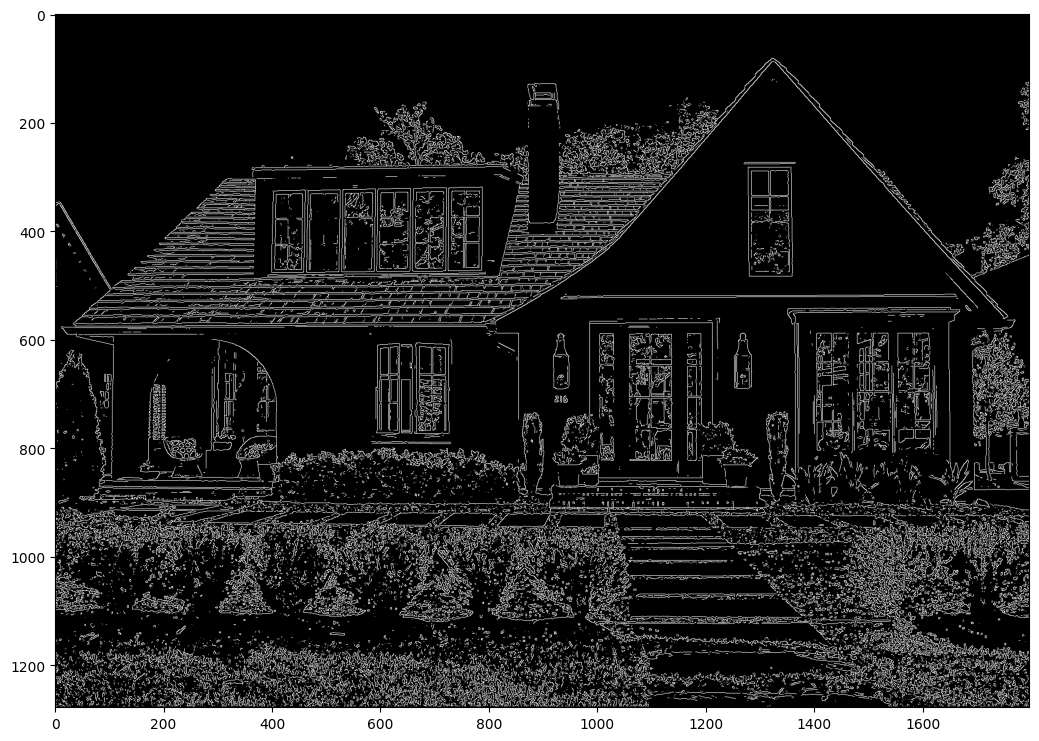

In [90]:
# Kornias Canny
# canny_result = kornia.filters.canny(tensor_img_gray, hysteresis=True)
# test = canny_result[1][0].permute(1,2,0).numpy()

resultsCanny = result[0].permute(1,2,0).numpy()
plt.imshow(resultsCanny, cmap="gray")


# 2- MyCannyFull

In [74]:
def MyCannyFull(img, sigma, tau, high_thresh, low_thresh):
    
    # step 1: smooth out the image using a 2d gaussian
    smoothed = kornia.filters.gaussian_blur2d(tensor_img_gray, (3, 3), (sigma,sigma))

    # step 2: compute the gradient and squared gradient magnitude
    dx_kernel = torch.tensor([[-1, 0, 1],
                          [-2, 0, 2],
                          [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    dy_kernel = torch.tensor([[-1, -2, -1],
                          [ 0,  0,  0],
                          [ 1,  2,  1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    dx = F.conv2d(smoothed, dx_kernel)
    dy = F.conv2d(smoothed, dy_kernel)

    mag = torch.sqrt(dx ** 2 + dy ** 2)
    theta = torch.atan2(dy, dx)
    
    # step 3: perform non maximum suppression
    rows, cols = mag.shape[2:]
    suppressed = torch.zeros_like(mag)
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            # determine which direction the edge is pointing
            angle = theta[0, 0, i, j].item() * 180.0 / math.pi
            if angle < 0:
                angle += 180.0
            # round the angle to the nearest 45 degrees
            if (angle >= 0 and angle < 22.5) or (angle >= 157.5 and angle < 180):
                q = mag[0, 0, i, j+1]
                r = mag[0, 0, i, j-1]
            elif (angle >= 22.5 and angle < 67.5):
                q = mag[0, 0, i+1, j+1]
                r = mag[0, 0, i-1, j-1]
            elif (angle >= 67.5 and angle < 112.5):
                q = mag[0, 0, i+1, j]
                r = mag[0, 0, i-1, j]
            elif (angle >= 112.5 and angle < 157.5):
                q = mag[0, 0, i-1, j+1]
                r = mag[0, 0, i+1, j-1]
            # check if the current pixel is a local maximum in its neighborhood
            p = mag[0, 0, i, j]
            if p >= q and p >= r:
                suppressed[0, 0, i, j] = p   


    # Step 4: Thresholding
    strong_edges = (suppressed >= high_thresh).float()
    weak_edges = ((suppressed < high_thresh) & (suppressed >= low_thresh)).float()
    
    edge_map = strong_edges.clone()
    queue = deque()
    for i in range(rows-1):
        for j in range(cols-1):
            # bfs
            if strong_edges[0, 0, i, j] > 0:
                queue.append((i, j))
                while queue:
                    x, y = queue.popleft()
                    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < rows and 0 <= ny < cols:
                            if edge_map[0, 0, nx, ny] == 0 and suppressed[0, 0, nx, ny] >= low_thresh:
                                edge_map[0, 0, nx, ny] = 1
                                queue.append((nx, ny))

    # Set all weak edges to 0
    edge_map[weak_edges == 1] = 0

    return edge_map
    

In [75]:
resultMyCannyFull = MyCannyFull(tensor_img_gray, 1, 0.5, 0.2, 0.1)

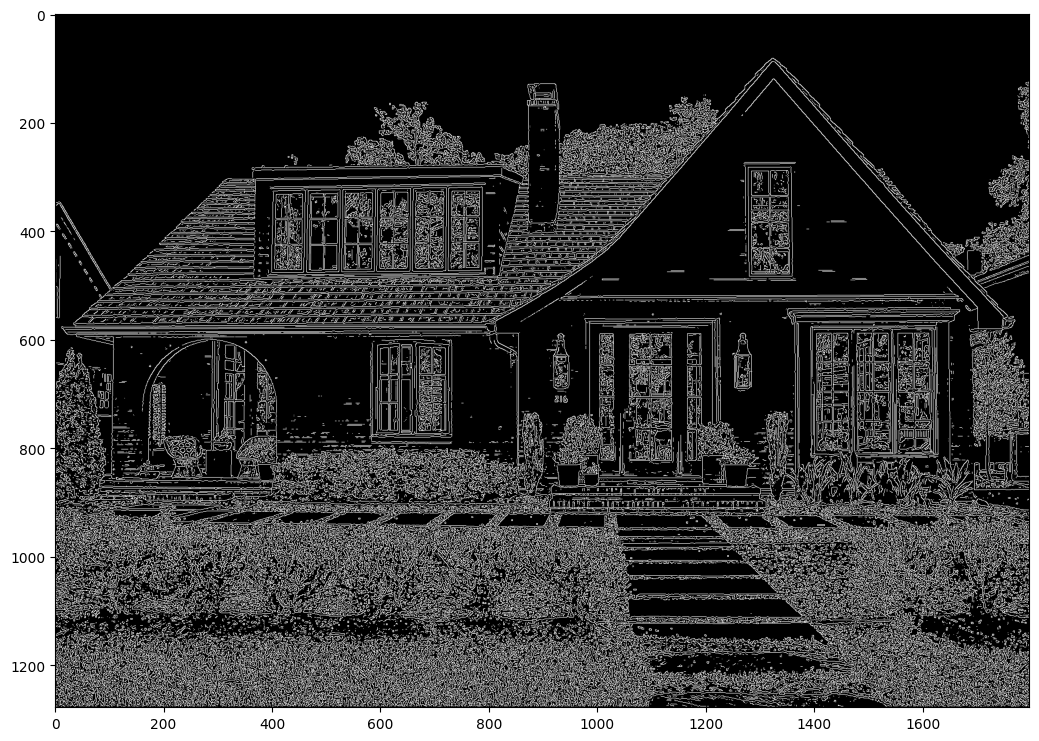

In [76]:
i = resultMyCannyFull[0].permute(1,2,0).numpy()
plt.imshow(i, cmap="gray")